## Import libraries

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import joblib as jl
from sklearn import preprocessing




## Import Dataset

In [83]:
dataset = pd.read_csv('Data/dogs_intakes_outcomes_clean.csv')



# Check for null values in important features

In [84]:
dataset.apply(lambda x: sum(x.isnull()/len(dataset)))

age_upon_outcome              0.000000
animal_id_outcome             0.000000
date_of_birth                 0.000000
outcome_subtype               0.696499
outcome_type                  0.000000
sex_upon_outcome              0.000022
age_upon_outcome_(days)       0.000000
age_upon_outcome_(years)      0.000000
age_upon_outcome_age_group    0.000000
outcome_datetime              0.000000
outcome_month                 0.000000
outcome_year                  0.000000
outcome_monthyear             0.000000
outcome_weekday               0.000000
outcome_hour                  0.000000
outcome_number                0.000000
dob_year                      0.000000
dob_month                     0.000000
dob_monthyear                 0.000000
age_upon_intake               0.000000
animal_id_intake              0.000000
animal_type                   0.000000
breed                         0.000000
color                         0.000000
found_location                0.000000
intake_condition         

## Setting dependent variable categories

In [85]:
dataset =  dataset.loc[(dataset['outcome_type'] == 'Adoption')                                  
                                 | (dataset['outcome_type'] == 'Transfer')
                                 | (dataset['outcome_type'] == 'Return to Owner')]

#dataset['outcome_subtype'] = np.where(pd.isnull(dataset['outcome_subtype']), 
#                                           dataset['outcome_type'], 
#                                           dataset['outcome_subtype'])

In [86]:
x = dataset.filter(items=['sex', 'spay/neuter', 'mixed_breed', 'time_in_shelter_days_12',
                         'coat', 'intake_hour', 'intake_weekday', 'intake_month', 'age_upon_intake_age_group',
                         'intake_condition', 'intake_type', 'Puppy/Dog_intake', 'Bully_breed'])

# ['sex', 'spay/neuter', 'mixed_breed', 'breed', 'time_in_shelter_days_6', 'coat'
#                         , 'intake_hour', 'intake_weekday', 'intake_month', 'age_upon_intake_age_group',
#                         'intake_condition', 'intake_type', 'Puppy/Dog_intake']

In [87]:
for col in x:
    x[col] = x[col].astype('category')
    
y = dataset['outcome_type'].astype('category')

In [88]:
xd = pd.get_dummies(x)
xnames = xd.columns
xarr = np.array(xd)


In [89]:
yarr, ynames = pd.factorize(dataset['outcome_type'])

# Split x and y arrays into training and testing sets

In [90]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV

x_train, x_test, y_train, y_test = train_test_split(xarr, yarr, 
                                                    test_size=0.3, random_state=1)

In [91]:
scaler = preprocessing.StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Use PCA to reduce dimensions

In [92]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(x_train_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [93]:
print(len(pca.components_))


121


# Chain kbest feature extration to PCA with feature union

In [94]:
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier

feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model = Pipeline([
    ('feature_union', feature_union),
    ('rf', RandomForestClassifier(n_estimators=500, criterion='gini', 
                                  class_weight='balanced_subsample', bootstrap=True, 
                                  oob_score=True))
])

prediction_model.fit(x_train_scaled, y_train)

Pipeline(memory=None,
         steps=[('feature_union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pca',
                                                 PCA(copy=True,
                                                     iterated_power='auto',
                                                     n_components=None,
                                                     random_state=None,
                                                     svd_solver='auto', tol=0.0,
                                                     whiten=False)),
                                                ('kbest',
                                                 SelectKBest(k=10,
                                                             score_func=<function f_classif at 0x000001E20D69D9D8>))],
                              transformer_weights=None, verbose=False)),
                ('rf',
                 RandomForestClassifier(bootstrap=True,
               

##### import warnings
warnings.simplefilter('ignore')

prediction_model.fit(x_train_scaled, y_train)

# Test prediction with StratifiedKFold

In [95]:
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.simplefilter('ignore')

cv = StratifiedKFold(3)
cv_score = cross_val_score(prediction_model, x_train_scaled, y_train, cv=cv, scoring='accuracy')
cv_predict_score = cross_val_predict(prediction_model, x_train_scaled, y_train, cv=cv)

In [96]:
print(cv_score)
print(np.mean(cv_score))

print(accuracy_score(y_train, cv_predict_score))

[0.74 0.75 0.75]
0.7476464227388885
0.7489913072002624


In [97]:
rf_pred = prediction_model.predict(x_test_scaled)

In [98]:
print(accuracy_score(y_test, rf_pred))

0.7407010561763355


Confusion matrix, without normalization
[[3232   82  587]
 [ 319  647 2066]
 [ 215  119 5799]]
Normalized confusion matrix
[[0.83 0.02 0.15]
 [0.11 0.21 0.68]
 [0.04 0.02 0.95]]


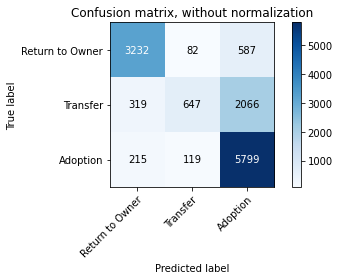

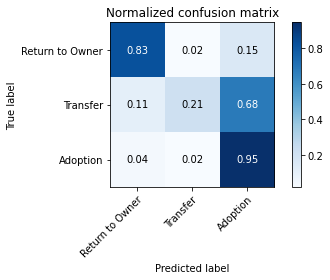

In [99]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = ynames
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, rf_pred, classes=ynames,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, rf_pred, classes=ynames, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

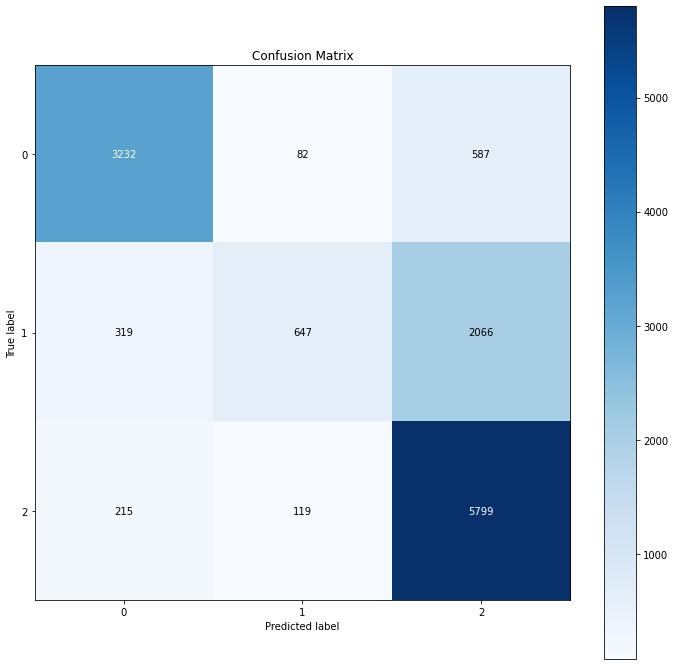

In [100]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_test, rf_pred, figsize=(12,12))

# Parameter tuning

In [101]:
criterion = ['gini', 'entropy']
components = [70, 100, 121]
estimators = [100, 250, 500, 750]
k = [10, 15, 20]

In [103]:
from sklearn.multiclass import OneVsRestClassifier

feature_union = FeatureUnion([
    ('pca', PCA()),
    ('kbest', SelectKBest())
])

prediction_model_tune = Pipeline([
    ('feature_union', feature_union),
    ('rf', OneVsRestClassifier(RandomForestClassifier(class_weight='balanced_subsample', 
                                                      bootstrap=True, oob_score=True)))
])

rf_gridcv = GridSearchCV(prediction_model_tune, dict(feature_union__pca__n_components=components, 
                                                     feature_union__kbest__k=k, 
                                                     rf__estimator__n_estimators=estimators, 
                                                     rf__estimator__criterion=criterion), 
                         scoring='accuracy', cv=cv, return_train_score=True)

In [ ]:
rf_gridcv.fit(x_train_scaled, y_train)

# Save model

In [ ]:
joblib.dump(rf_gridcv, 'Data/rfg2.pkl') 

# Convert grid to pandas dataframa

In [ ]:
results = pd.DataFrame(rf_gridcv.cv_results_)
results.sort_values(by='rank_test_score', ascending=False, inplace=True)
results.head()